In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import time

import pickle
import joblib
import contextlib
from tqdm import tqdm
from joblib import Parallel, delayed

# Parallel Job Progress Bar

In [2]:
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""

    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback

    try:
        yield tqdm_object

    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

# Defining $f_\epsilon$, $f'_\epsilon$, $U_\epsilon$, $\nabla_\theta U_\epsilon$ in CVaR Example

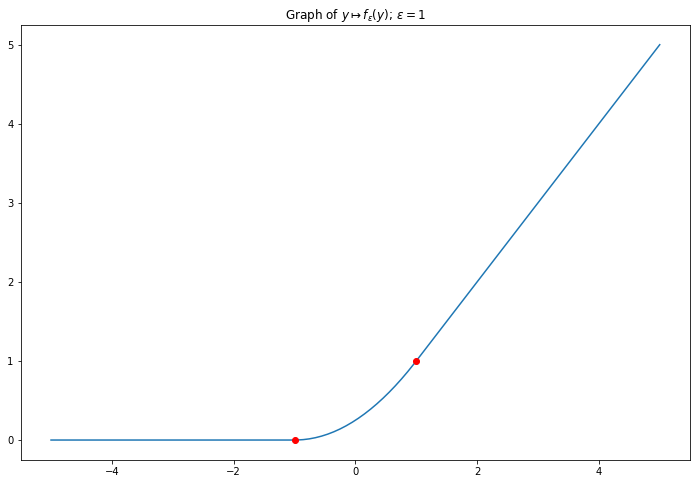

In [3]:
def f_epsilon(y, eps):
    return np.select(
        [y>eps, np.logical_and(y>=-eps, y<=eps)],
        [y, ((y+eps)**2)/(4*eps)]
    )

plt.figure(figsize=(12,8))
plt.plot(np.linspace(-5,5,100), f_epsilon(np.linspace(-5,5,100), 1))
plt.plot([-1,1],[0,1], 'o', color='red')
plt.title(r'Graph of $y\mapsto f_\epsilon(y)$; $\epsilon=1$')
plt.show()

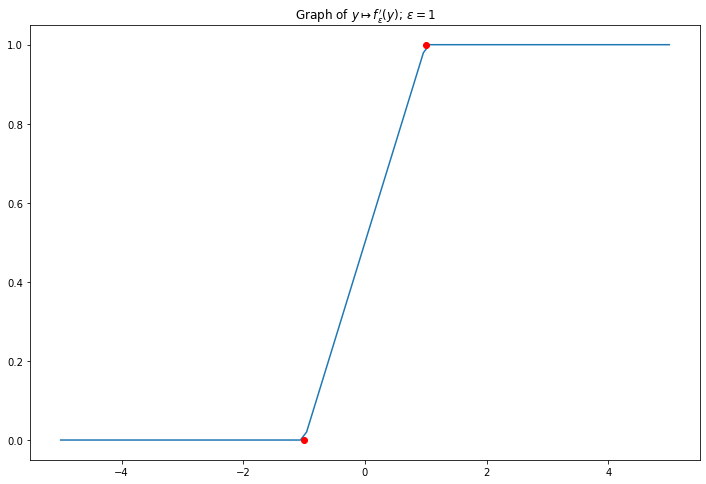

In [4]:
def grad_f_epsilon(y, eps):
    return np.select(
        [y>eps, np.logical_and(y>=-eps, y<=eps)],
        [1, (y+eps)/(2*eps)]
    )

plt.figure(figsize=(12,8))
plt.plot(np.linspace(-5,5,100), grad_f_epsilon(np.linspace(-5,5,100), 1))
plt.plot([-1,1],[0,1], 'o', color='red')
plt.title(r"Graph of $y\mapsto f_\epsilon'(y)$; $\epsilon=1$")
plt.show()

In [5]:
def softmax(w):
    return np.exp(w)/np.sum(np.exp(w))

# vectorise in x
def U_epsilon(theta, x, eps=0.01, gamma=0.9, **kwargs):
    rho1, rho2 = kwargs.get('rho1'), kwargs.get('rho2')
    w, v = theta[:-1], theta[-1]
    ip = np.dot(x, softmax(w))
    return -rho1*ip+rho2*(v+f_epsilon(-ip-v, eps)/(1-gamma))

# vectorise in x; rows correspond to different values of x
def grad_U_epsilon(theta, x, eps=0.01, gamma=0.9, **kwargs):
    rho1, rho2 = kwargs.get('rho1'), kwargs.get('rho2')
    w, v = theta[:-1], theta[-1]
    f_prime = grad_f_epsilon(-np.dot(x, softmax(w))-v, eps)
    grad = np.zeros((x.shape[0], theta.shape[0]))
    grad[:,:-1] = -softmax(w)*(x-(np.dot(x, np.exp(w))/np.sum(np.exp(w)))[:,None])*(rho1+rho2*f_prime/(1-gamma))[:,None]
    grad[:,-1] = rho2*(1-f_prime/(1-gamma))
    return grad

# Discretisation of Compact Support

In [6]:
def set_prod(*arr_lst):
    n_arrs = len(arr_lst)
    datatype = np.result_type(*arr_lst)
    arr = np.empty([len(a) for a in arr_lst] + [n_arrs], dtype=datatype)
    for i, a in enumerate(np.ix_(*arr_lst)):
        arr[...,i] = a
    return arr.reshape(-1, n_arrs)

In [7]:
ell = 2
j = 4

# returns from -1 to 1
xi_range = [-0.5, 0.5]

# discretised space
dyadic_set = np.arange(-2**(ell-1), 2**(ell-1), 1/2**j) # dyadic
dyadic_set = dyadic_set[np.logical_and(dyadic_set >= xi_range[0], dyadic_set <= xi_range[1])]
dyadic_set

# m = d-1 number of assets
m = 5

discrete_space = set_prod(*[dyadic_set]*m)

In [8]:
dyadic_set

array([-0.5   , -0.4375, -0.375 , -0.3125, -0.25  , -0.1875, -0.125 ,
       -0.0625,  0.    ,  0.0625,  0.125 ,  0.1875,  0.25  ,  0.3125,
        0.375 ,  0.4375,  0.5   ])

In [9]:
discrete_space

array([[-0.5   , -0.5   , -0.5   , -0.5   , -0.5   ],
       [-0.5   , -0.5   , -0.5   , -0.5   , -0.4375],
       [-0.5   , -0.5   , -0.5   , -0.5   , -0.375 ],
       ...,
       [ 0.5   ,  0.5   ,  0.5   ,  0.5   ,  0.375 ],
       [ 0.5   ,  0.5   ,  0.5   ,  0.5   ,  0.4375],
       [ 0.5   ,  0.5   ,  0.5   ,  0.5   ,  0.5   ]])

# (Robust) SGLD

In [10]:
def iota(alpha):
    return np.log(np.cosh(alpha))

def grad_iota(alpha):
    return np.tanh(alpha)

# returns vector; evaluated at all points of discretised space
def F_delta(theta_bar, x, delta, p, U, iota, discrete_space, **kwargs):
    theta, alpha = theta_bar[:-1], theta_bar[-1]
    return np.exp(
        (U(theta, discrete_space, **kwargs)-iota(alpha)*np.linalg.norm(x-discrete_space, axis=1)**p)/delta
    )

def grad_V_delta(theta_bar, x, delta, p, eta1, eta2, U, iota, grad_U, grad_iota, discrete_space, **kwargs):
    theta, alpha = theta_bar[:-1], theta_bar[-1]
    F = F_delta(theta_bar, x, delta, p, U, iota, discrete_space, **kwargs)
    grad_V = np.zeros(theta_bar.shape[0])
    
    grad_V[:-1] = eta1*theta + np.dot(F, grad_U(theta, discrete_space, **kwargs))/np.sum(F)
    grad_V[-1] = (
        eta2*iota(alpha)*grad_iota(alpha)-
        grad_iota(alpha)*np.dot(F, np.linalg.norm(x-discrete_space, axis=1)**p)/np.sum(F)
    )
    
    return grad_V

In [11]:
def sgld(n_iter, step, beta, theta_0, x_hist, grad_U, **kwargs): 
    # initialise algorithm
    theta = theta_0
    
    # generate random normal samples
    Z = np.random.normal(size=(n_iter, theta_0.shape[0]))
    
    # generate data
    X_idx = np.random.choice(x_hist.shape[0], size=n_iter)
    
    for n in range(n_iter):
        theta = (theta +
            np.sqrt(2*step/beta)*Z[n] - 
            step*grad_U(theta, x_hist[X_idx[n]][None,:], **kwargs).ravel()
        )
        
        #print(f"Iteration No. {n}")
        #print(theta)
        #print('\n')
    return theta

In [12]:
def robust_sgld(n_iter, step, beta, 
                theta_bar_0, x_hist, delta, p, eta1, eta2, U, iota, grad_U, grad_iota, discrete_space, **kwargs):
    
    # initialise algorithm
    theta_bar = theta_bar_0
    
    # generate random normal samples
    Z = np.random.normal(size=(n_iter, theta_bar_0.shape[0]))
    
    # generate data
    X_idx = np.random.choice(x_hist.shape[0], size=n_iter)
    
    for n in range(n_iter):
        theta_bar = (theta_bar +
            np.sqrt(2*step/beta)*Z[n] - 
            step*grad_V_delta(theta_bar, x_hist[X_idx[n]], delta, p, eta1, eta2, U, iota, grad_U, grad_iota, discrete_space, **kwargs)
        )
        
        #print(f"Iteration No. {n}")
        #print(theta_bar)
        #print('\n')
    return theta_bar

# Backtest on ETF Data

In [13]:
# portfolio constituents
symbol_list = ['SPY','GDX','EEM','XLF','USO']

# download data
data = yf.download(
    symbol_list, 
    start='2015-01-05', 
    end='2023-01-01',
    interval='1wk'
)['Adj Close']

# create a Pandas dataframe 
close_df = pd.DataFrame(data)
ret_df = close_df.pct_change().dropna()

[*********************100%***********************]  5 of 5 completed


In [14]:
# set algorithm parameters
n_iter = 10000
step = 0.01
beta = 10
theta_0 = np.array([0,0,0,0,0,0])
theta_bar_0 = np.array([0,0,0,0,0,0,0])
delta = 0.1
p = 2 

#eta1 = 0.1
#eta2 = 1 # bigger eta2 means larger "radius"


#rho1 = 0 # i.e. min CVaR
#rho2 = 1

# combinations for each (rho1, rho2):
# - eta1 = .1, eta2 = 1
# - eta1 = .1, eta2 = 10
# - eta1 = 1, eta2 = 1
# - eta1 = 10, eta2 = 1 (maybe)

In [15]:
# set rolling window parameters
n_train = 52 # weeks
n_test = 26 # weeks; rebalancing period

# no. of train-test rolling windows 
n_windows = (ret_df.shape[0]-n_train)//n_test

n_train, n_test, n_windows, n_windows * n_test + n_train

(52, 26, 14, 416)

In [16]:
def sgld_backtest(rho1=1, rho2=1):
    # store weights and portfolio values
    weights_df_lst = []
    val_df_lst = []
    V = 10000

    np.random.seed(5)

    for i in range(n_windows):
        train_df = ret_df.iloc[(i*n_test):(i*n_test+n_train)]
        test_df = ret_df.iloc[(i*n_test+n_train):((i+1)*n_test+n_train)]
        val_df = close_df.iloc[(i*n_test+n_train+1):((i+1)*n_test+n_train+1)]
        
        theta = sgld(
            n_iter=n_iter, 
            step=step, 
            beta=beta, 
            theta_0=theta_0, 
            x_hist=train_df.to_numpy(), 
            grad_U=grad_U_epsilon,
            rho1=rho1,
            rho2=rho2
        )

        weights = softmax(theta[:-1])
        allocation = weights*V/close_df.iloc[i*n_test+n_train].to_numpy()
        weights_df_lst.append(val_df*0+weights)
        val_df_lst.append(val_df*allocation)

        # update portfolio value at end of test period
        V = np.dot(allocation, close_df.iloc[(i+1)*n_test+n_train].to_numpy())

    weights_df = pd.concat(weights_df_lst)
    val_df = pd.concat(val_df_lst)
    
    return weights_df, val_df

In [17]:
def robust_sgld_backtest(rho1=1, rho2=1, eta1=0.1, eta2=1):
    # store weights and portfolio values
    weights_df_lst = []
    val_df_lst = []
    V = 10000

    np.random.seed(5)
    
    for i in range(n_windows):
        train_df = ret_df.iloc[(i*n_test):(i*n_test+n_train)]
        test_df = ret_df.iloc[(i*n_test+n_train):((i+1)*n_test+n_train)]
        val_df = close_df.iloc[(i*n_test+n_train+1):((i+1)*n_test+n_train+1)]
        
        theta_bar = robust_sgld(
            n_iter=n_iter, 
            step=step, 
            beta=beta, 
            theta_bar_0=theta_bar_0, 
            x_hist=train_df.to_numpy(), 
            delta=delta, 
            p=p, 
            eta1=eta1, 
            eta2=eta2, 
            U=U_epsilon, 
            iota=iota, 
            grad_U=grad_U_epsilon, 
            grad_iota=grad_iota, 
            discrete_space=discrete_space,
            rho1=rho1,
            rho2=rho2
        )

        weights = softmax(theta_bar[:-2])
        allocation = weights*V/close_df.iloc[i*n_test+n_train].to_numpy()

        weights_df_lst.append(val_df*0+weights)
        val_df_lst.append(val_df*allocation)

        # update portfolio value at end of test period
        V = np.dot(allocation, close_df.iloc[(i+1)*n_test+n_train].to_numpy())

    weights_df = pd.concat(weights_df_lst)
    val_df = pd.concat(val_df_lst)
    
    return weights_df, val_df

In [18]:
def robust_sgld_backtest_parallel(rho1=1, rho2=1, eta1=0.1, eta2=1, n_jobs=-1):
    # store weights and portfolio values
    val_df_lst = []
    
    V = 10000

    np.random.seed(5)
    
    def _get_train_test_val_df(i):
        train_df = ret_df.iloc[(i*n_test):(i*n_test+n_train)]
        test_df = ret_df.iloc[(i*n_test+n_train):((i+1)*n_test+n_train)]
        val_df = close_df.iloc[(i*n_test+n_train+1):((i+1)*n_test+n_train+1)]
        return train_df, test_df, val_df
    
    def _robust_sgld_backtest_single_period(i):
        train_df, test_df, val_df = _get_train_test_val_df(i)
        
        theta_bar = robust_sgld(
            n_iter=n_iter, 
            step=step, 
            beta=beta, 
            theta_bar_0=theta_bar_0, 
            x_hist=train_df.to_numpy(), 
            delta=delta, 
            p=p, 
            eta1=eta1, 
            eta2=eta2, 
            U=U_epsilon, 
            iota=iota, 
            grad_U=grad_U_epsilon, 
            grad_iota=grad_iota, 
            discrete_space=discrete_space,
            rho1=rho1,
            rho2=rho2
        )

        weights = softmax(theta_bar[:-2])
        return val_df*0+weights
    
    with tqdm_joblib(tqdm(desc='Robust SGLD Backtesting', total=n_windows)) as progress_bar:
        weights_df_lst = Parallel(n_jobs=n_jobs)(
            delayed(_robust_sgld_backtest_single_period)(i) for i in range(n_windows)
        )
    
    weights_df = pd.concat(weights_df_lst)
    
    for i in range(n_windows):
        train_df, test_df, val_df = _get_train_test_val_df(i)

        weights = weights_df.loc[val_df.index].iloc[0].to_numpy()
        allocation = weights*V/close_df.iloc[i*n_test+n_train].to_numpy()

        val_df_lst.append(val_df*allocation)

        # update portfolio value at end of test period
        V = np.dot(allocation, close_df.iloc[(i+1)*n_test+n_train].to_numpy())

    val_df = pd.concat(val_df_lst)
        
    return weights_df, val_df

In [19]:
rho1 = 1.0
rho2 = 1.0
eta2_lst = [0.01, 0.05, 0.075, 0.1, 0.5, 1.0]

"""
results_dict = {}

# backtest sgld
results_dict['SGLD'] = sgld_backtest(rho1=rho1, rho2=rho2)

# backtest robust sgld
for i, eta2 in enumerate(eta2_lst):
    results_dict[f'Robust SGLD {i}'] = robust_sgld_backtest_parallel(rho1=rho1, rho2=rho2, eta1=0.1, eta2=eta2, n_jobs=-1)
    
with open('results2.pkl', 'wb') as f:
    pickle.dump(results_dict, f)
"""

"\nresults_dict = {}\n\n# backtest sgld\nresults_dict['SGLD'] = sgld_backtest(rho1=rho1, rho2=rho2)\n\n# backtest robust sgld\nfor i, eta2 in enumerate(eta2_lst):\n    results_dict[f'Robust SGLD {i}'] = robust_sgld_backtest_parallel(rho1=rho1, rho2=rho2, eta1=0.1, eta2=eta2, n_jobs=-1)\n    \nwith open('results2.pkl', 'wb') as f:\n    pickle.dump(results_dict, f)\n"

In [20]:
with open('results.pkl', 'rb') as f:
    results_dict = pickle.load(f)

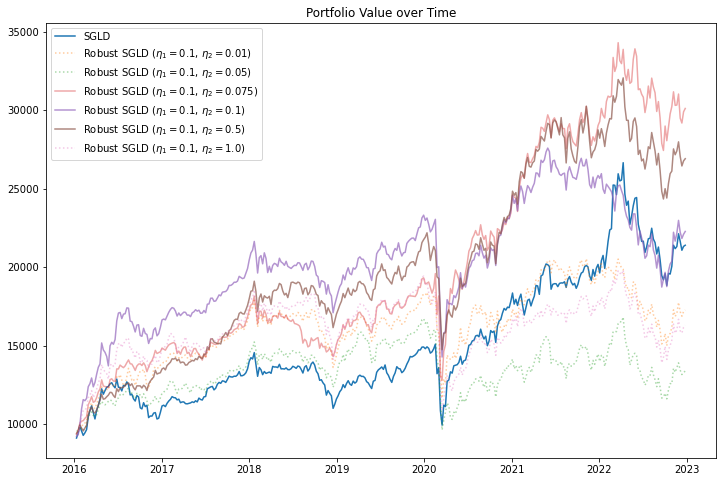

In [21]:
plt.figure(figsize=(12,8))
for key, (weights_df, val_df) in results_dict.items():
    if key == 'SGLD':
        plt.plot(val_df.sum(axis=1), label='SGLD')
    else:
        ls = '-' if eta2_lst[int(key[-1])] in [0.075, 0.1, .5] else ':'
        alpha = 0.7 if eta2_lst[int(key[-1])] in [0.1, .5] else 0.4
        plt.plot(val_df.sum(axis=1), ls=ls, alpha=alpha, label=f'Robust SGLD ($\eta_1=0.1$, $\eta_2={eta2_lst[int(key[-1])]}$)')

plt.legend()
plt.title('Portfolio Value over Time')
plt.savefig('portfolio_values.pdf', bbox_inches='tight')
plt.show()

In [22]:
# generate summary statistics
model = []
min_portfolio_value = []
max_portfolio_value = []
terminal_portfolio_value = []
min_return = []
max_return = []
mean_return = []
sd_return = []
sharpe_ratio = []


for key, (weights_df, val_df) in results_dict.items():
    model.append(key)
    min_portfolio_value.append(val_df.sum(axis=1).min())
    max_portfolio_value.append(val_df.sum(axis=1).max())
    terminal_portfolio_value.append(val_df.sum(axis=1).iloc[-1])
    min_return.append(val_df.sum(axis=1).pct_change().dropna().min()*100.0)
    max_return.append(val_df.sum(axis=1).pct_change().dropna().max()*100.0)
    mean_return.append(val_df.sum(axis=1).pct_change().dropna().mean()*100.0)
    sd_return.append(val_df.sum(axis=1).pct_change().dropna().std()*100.0)
    sharpe_ratio.append(val_df.sum(axis=1).pct_change().dropna().mean() / val_df.sum(axis=1).pct_change().dropna().std())

portfolio_summary_df = pd.DataFrame({
    'Model': model,
    'Min. Portfolio Value': min_portfolio_value,
    'Max. Portfolio Value': max_portfolio_value,
    'Initial Portfolio Value': 10000,
    'Terminal Portfolio Value': terminal_portfolio_value,
    'Min. Weekly Return (%)': min_return,
    'Max. Weekly Return (%)': max_return,
    'Mean Weekly Return (%)': mean_return,
    'Std. Dev. Weekly Return (%)': sd_return,
    'Sharpe Ratio': sharpe_ratio
})

del model, min_portfolio_value, max_portfolio_value, terminal_portfolio_value, min_return, max_return, mean_return, sd_return, sharpe_ratio

portfolio_summary_df.T#.style.hide(axis="columns").format(decimal='.', thousands=',', precision=2).to_latex()

,0,1,2,3,4,5,6
Model,SGLD,Robust SGLD 0,Robust SGLD 1,Robust SGLD 2,Robust SGLD 3,Robust SGLD 4,Robust SGLD 5
Min. Portfolio Value,9109.026369,9363.919799,9550.075597,9371.866426,9222.895464,9379.019029,9352.850107
Max. Portfolio Value,26646.679017,20529.782991,16808.489608,34290.070536,27576.661711,32050.204801,19802.226959
Initial Portfolio Value,10000,10000,10000,10000,10000,10000,10000
Terminal Portfolio Value,21389.066449,17267.832024,13379.949907,30100.183758,22267.138273,26900.633435,16290.161435
Min. Weekly Return (%),-20.075088,-14.117462,-17.710839,-28.109383,-18.227723,-13.292171,-20.327271
Max. Weekly Return (%),14.424406,14.369935,7.904248,14.310876,12.852383,7.169174,7.885892
Mean Weekly Return (%),0.28087,0.208328,0.135716,0.369132,0.287274,0.323117,0.1963
Std. Dev. Weekly Return (%),2.996064,2.805365,2.889042,2.999881,2.957746,2.535794,2.900292
Sharpe Ratio,0.093746,0.074261,0.046976,0.123049,0.097126,0.127422,0.067683
